### Import packages and data

In [36]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [37]:
df = pd.read_csv('../data/Train_call.txt', sep='\t', header=0, )
label = pd.read_csv('../data/Train_clinical.txt', sep='\t', index_col=0)
df

,Chromosome,Start,End,Nclone,Array.129,Array.34,Array.67,Array.24,Array.22,Array.36,...,Array.64,Array.89,Array.30,Array.35,Array.93,Array.10,Array.123,Array.100,Array.134,Array.130
0,1,2927,43870,3,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-1,0
1,1,85022,216735,4,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-1,0
2,1,370546,372295,4,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,-1,0
3,1,471671,786483,5,0,0,0,0,0,0,...,0,1,1,0,1,0,0,0,-1,0
4,1,792533,907406,13,0,0,0,0,0,0,...,0,1,1,0,1,0,0,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,23,153062077,153452633,57,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
2830,23,153466463,153491568,4,1,1,1,0,1,1,...,2,1,1,1,1,1,1,1,1,1
2831,23,153504394,153933426,55,1,1,1,0,1,1,...,2,1,1,1,1,1,1,1,1,1
2832,23,153938998,153989329,5,1,1,1,0,1,1,...,2,1,1,1,1,1,1,1,1,1


### Data visualization

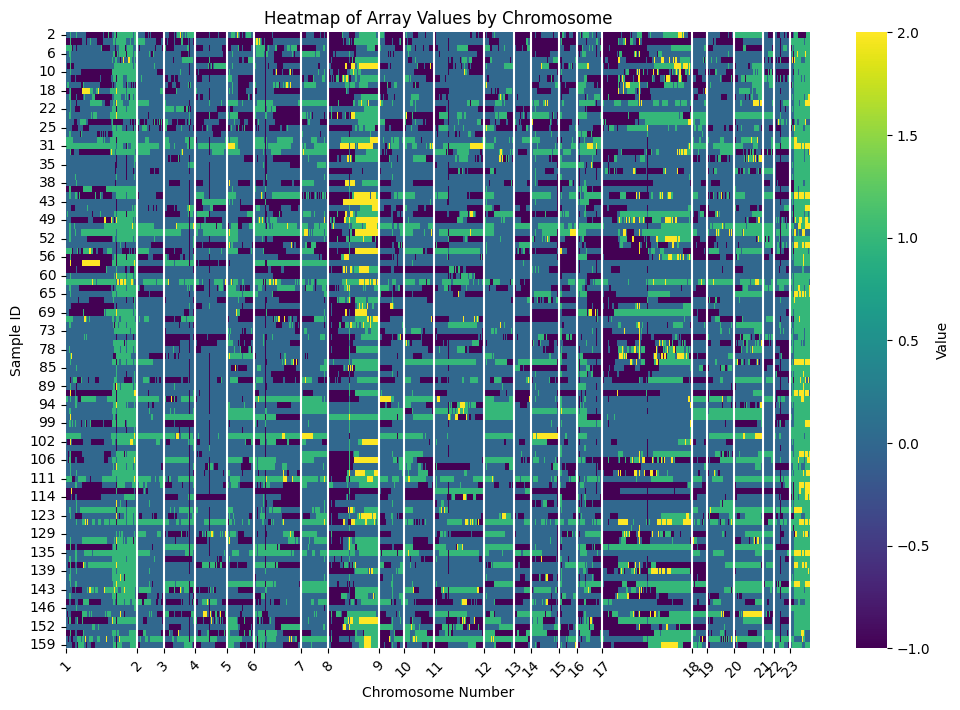

In [38]:
array_data = df.filter(regex='^Array\.\d+$')
# Extracting chromosome and position data
chromosome_position = df[['Chromosome', 'Start']].sort_values(by=['Chromosome', 'Start'])
# Mapping columns to simple ID numbers
array_data.columns = [int(col.split('.')[1]) for col in array_data.columns]

# Sort the columns by sample ID
array_data = array_data.reindex(sorted(array_data.columns), axis=1)

# Assuming 'df' and 'array_data' have already been defined and processed as before
chromosome_labels = df['Chromosome'].unique()  # Unique chromosome labels

# Creating the heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(array_data.T, cmap='viridis', cbar_kws={'label': 'Value'})

# Modify x-tick labels to show chromosome numbers only once per chromosome
# Create a new list for labels with positions
chromosome_positions = []
prev_chrom = None
for i, chrom in enumerate(df['Chromosome']):
    if chrom != prev_chrom:
        chromosome_positions.append(i)
        prev_chrom = chrom

# Set x-tick labels
ax.set_xticks([pos for pos in chromosome_positions])
ax.set_xticklabels(chromosome_labels)
plt.xticks(rotation=45)  # Rotate labels for better visibility

# Adding vertical lines after each chromosome
for pos in chromosome_positions[1:]:  # Skip the first position
    plt.axvline(x=pos, color='white')

plt.title('Heatmap of Array Values by Chromosome')
plt.xlabel('Chromosome Number')
plt.ylabel('Sample ID')
plt.show()


Text(0.5, 1.0, 'Correlation matrix of raw data')

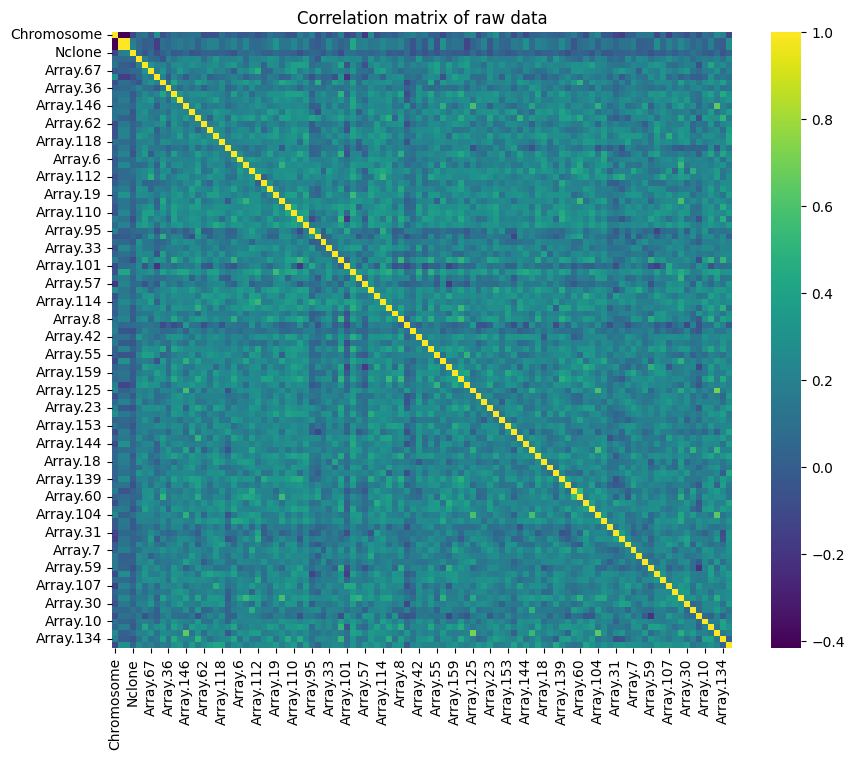

In [39]:
# correlation matrix for each gene
corr_matrix = df.iloc[4:].corr(method='pearson') 
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='viridis')
plt.title('Correlation matrix of raw data')

In [40]:
df_X = df.drop(['Chromosome', 'Start', 'End', "Nclone"], axis=1).T
X = np.array(df_X, dtype=np.float64)
le = LabelEncoder()

# Fit label encoder and return encoded labels
label['subgroup_encoded'] = le.fit_transform(label['Subgroup'])
y = label['subgroup_encoded']

df_y = pd.DataFrame(y)
df_X.to_csv('../data/X.csv', index=True)
df_y.to_csv('../data/y.csv', index=True)


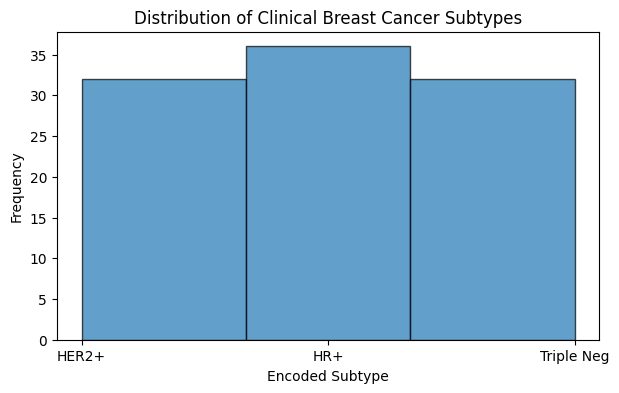

In [41]:
categories = ["HER2+", "HR+", "Triple Neg"]

# Histogram of the labels
plt.figure(figsize=(7, 4))  
plt.hist(y, bins=len(set(y)), alpha=0.7, edgecolor='black')  # Creates the histogram
plt.title('Distribution of Clinical Breast Cancer Subtypes')  # Adds a title
plt.xlabel('Encoded Subtype')  # Label for the x-axis
plt.ylabel('Frequency')  # Label for the y-axis
plt.xticks(range(len(categories)), categories)  # Ensures there is a tick for each class
plt.show()  # Displays the plot

### Linear Feature Selection using L1 Logistic Regression

In [42]:
# feature_data = pd.read_csv('../Data/Train_call.txt', delimiter='\t')
# feature_data = feature_data.drop(['Chromosome', 'Start', 'End', "Nclone"], axis=1).T
# label_data = pd.read_csv('../Data/Train_clinical.txt', delimiter='\t', index_col=0)
# label_data

In [43]:
# feature_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [44]:
# First Logistic Regression with L1 penalty
logreg1 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, multi_class='ovr')
logreg1.fit(X_train, y_train)

# Create a boolean mask for features with non-zero coefficients in any class
features_first_round = np.any(logreg1.coef_ != 0, axis=0)
selected_features_first_round = df_X.columns[features_first_round].tolist()

# Apply the mask to reduce X to significant features only
X_reduced_train = X_train[:, features_first_round]
X_reduced_test = X_test[:, features_first_round]

# Second Logistic Regression with L1 penalty on the reduced feature set
logreg2 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, multi_class='ovr')
logreg2.fit(X_reduced_train, y_train)

# Identify features with non-zero coefficients in the second round
features_second_round = np.any(logreg2.coef_ != 0, axis=0)
selected_features_second_round = df_X.columns[features_first_round][features_second_round].tolist()

# Output selected features
print("Selected features in the first round:", selected_features_first_round, 
      "\n length:", len(selected_features_first_round))
print("Selected features in the second round:", selected_features_second_round,
      "\n length:", len(selected_features_second_round))

# Evaluate model performance on the test set with reduced features
y_pred_first = logreg1.predict(X_test)
accuracy_first = accuracy_score(y_test, y_pred_first)
print("Accuracy on the test set (First Model):", accuracy_first)

y_pred_second = logreg2.predict(X_reduced_test)
accuracy_second = accuracy_score(y_test, y_pred_second)
print("Accuracy on the test set (Second Model):", accuracy_second)

Selected features in the first round: [174, 189, 192, 229, 230, 261, 263, 385, 623, 671, 744, 745, 746, 761, 765, 771, 791, 800, 801, 802, 818, 851, 854, 857, 888, 1059, 1065, 1087, 1160, 1243, 1302, 1303, 1306, 1551, 1559, 1656, 1663, 1679, 1788, 1895, 1897, 1898, 1902, 1910, 1994, 2017, 2026, 2058, 2083, 2130, 2184, 2206, 2207, 2212, 2213, 2214, 2218, 2221, 2382, 2547, 2549, 2662, 2723, 2732, 2742, 2775, 2776, 2777, 2789, 2791, 2816, 2817, 2818, 2829] 
 length: 74
Selected features in the second round: [174, 189, 192, 229, 230, 261, 385, 623, 671, 744, 745, 761, 765, 771, 791, 800, 801, 802, 818, 851, 854, 857, 888, 1065, 1087, 1160, 1243, 1302, 1303, 1306, 1559, 1656, 1663, 1679, 1788, 1895, 1898, 1902, 1910, 1994, 2017, 2026, 2058, 2083, 2130, 2184, 2206, 2207, 2212, 2213, 2218, 2221, 2382, 2547, 2549, 2662, 2723, 2732, 2742, 2776, 2789, 2791, 2817, 2818] 
 length: 64
Accuracy on the test set (First Model): 0.7666666666666667
Accuracy on the test set (Second Model): 0.8


In [56]:
selected_features_l1 = selected_features_second_round

- C Parameter: C is the inverse of regularization strength; smaller values specify stronger regularization. You might need to tune this parameter using, for example, cross-validation.  
- Feature Scaling: Logistic regression is also sensitive to the scale of variables, so it is crucial to scale features before applying these techniques.  
- Model Evaluation: The model's performance is evaluated using accuracy, which is a common metric for classification tasks. Depending on the specific characteristics of your problem (e.g., if the classes are imbalanced), you might prefer other metrics such as F1-score or ROC AUC.  

### Non-Linear Feature Selection using Random Forest

In [46]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from scipy.stats import randint as sp_randint
import time

def optimize_rfc_grid_search(x_data, y_targets):
    # Random Forest classifier to be optimized
    rfc = RandomForestClassifier(random_state=2)

    # Step 1: Define the parameter space for RandomizedSearchCV
    param_dist = {
        "n_estimators": sp_randint(10, 750),
        "max_leaf_nodes": sp_randint(20, 1000),
        "max_depth": sp_randint(20, 500),
        "min_samples_split": sp_randint(2, 250),
        "max_features": sp_randint(3, 100)
    }

    # Step 2: Execute RandomizedSearchCV
    n_iter_search = 50  # Number of parameter settings that are sampled
    random_search = RandomizedSearchCV(rfc, param_distributions=param_dist,
                                       n_iter=n_iter_search, scoring=make_scorer(f1_score, average='micro'), cv=4, verbose=1)
    
    start_time = time.time()
    random_search.fit(x_data, y_targets)

    print(f"Random Search completed in {time.time() - start_time:.2f} seconds. Starting Grid Search...")

    # Step 3: Identify the best parameters from the random search
    best_params = random_search.best_params_

    # Step 4: Define a narrower search space for GridSearchCV around the best parameters found
    param_grid = {
        "n_estimators": [best_params['n_estimators'] - 3, best_params['n_estimators'], best_params['n_estimators'] + 3],
        "max_leaf_nodes": [best_params['max_leaf_nodes'] - 5, best_params['max_leaf_nodes'], best_params['max_leaf_nodes'] + 5],
        "max_depth": [best_params['max_depth'] - 5, best_params['max_depth'], best_params['max_depth'] + 5],
        "min_samples_split": [best_params['min_samples_split'] - 3, best_params['min_samples_split'], best_params['min_samples_split'] + 3],
        "max_features": [max(1, best_params['max_features'] - 3), best_params['max_features'], best_params['max_features'] + 4]
    }

    # Step 5: Execute GridSearchCV
    grid_search = GridSearchCV(rfc, param_grid=param_grid, scoring=make_scorer(f1_score, average='micro'), cv=4, verbose=1)

    # Adjust ranges to ensure they are valid (e.g., positive integers)
    for key in param_grid.keys():
        param_grid[key] = [np.max([x, param_dist[key].a]) for x in param_grid[key]]  # Ensure within original bounds

    start_time = time.time()

    grid_search.fit(x_data, y_targets)

    print(f"Grid Search completed in {time.time() - start_time:.2f} seconds.")

    # Step 6: Report the best parameters found
    print("Best parameters found by grid search:", grid_search.best_params_)
    return grid_search.best_params_

# Call the function with your data and target variables
# best_params = optimize_rfc_with_random_and_grid_search(x_data, y_targets)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [70]:
m_rf = RandomForestClassifier(n_estimators = 20, max_features = 3, random_state=42).fit(X_train, y_train)
y_pred_std = m_rf.predict(X_test)

print(classification_report(y_test, y_pred_std, zero_division=0))

              precision    recall  f1-score   support

           0       0.47      0.62      0.53        13
           1       0.17      0.12      0.14         8
           2       0.29      0.22      0.25         9

    accuracy                           0.37        30
   macro avg       0.31      0.32      0.31        30
weighted avg       0.33      0.37      0.34        30



In [49]:
best_params = optimize_rfc_grid_search(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Random Search completed in 33.42 seconds. Starting Grid Search...
Fitting 4 folds for each of 243 candidates, totalling 972 fits
Grid Search completed in 115.26 seconds.
Best parameters found by grid search: {'max_depth': 250, 'max_features': 63, 'max_leaf_nodes': 351, 'min_samples_split': 3, 'n_estimators': 220}


In [75]:
m_rf_optimized = RandomForestClassifier(random_state=42, n_estimators = int(best_params["n_estimators"]), max_depth = int(best_params["max_depth"]), max_leaf_nodes = int(best_params["max_leaf_nodes"]), min_samples_split = int(best_params["min_samples_split"]), max_features = int(best_params["max_features"])).fit(X_train, y_train)
y_pred = m_rf_optimized.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.73      0.62      0.67        13
           1       0.30      0.38      0.33         8
           2       0.44      0.44      0.44         9

    accuracy                           0.50        30
   macro avg       0.49      0.48      0.48        30
weighted avg       0.53      0.50      0.51        30



In [76]:
def feature_importance(model, X_train):

    # Extract feature importances
    feature_importances = model.feature_importances_

    # Create generic feature names if not already provided
    if hasattr(X_train, 'columns'):
        feature_names = X_train.columns
    else:
        feature_names = [f"{i}" for i in range(X_train.shape[1])]

    # Sort the feature importances in descending order and get the indices
    indices = np.argsort(feature_importances)[::-1]

    # Select the top 50 features
    top_indices = indices[:100]
    
    # # Adjust the size of the plot to accommodate 50 features nicely
    # plt.figure(figsize=(15, 10))
    # plt.title("Top 50 Feature Importances")
    # plt.bar(range(100), feature_importances[top_indices], color="r", align="center")
    
    # # Set the ticks to be the names of the top 50 features
    # plt.xticks(range(100), [feature_names[i] for i in top_indices], rotation=90)
    # plt.xlim([-1, 100])
    # plt.tight_layout()  # Adjust layout to not cut off labels
    # plt.show()

    return top_indices

In [77]:
selected_features_rf = feature_importance(m_rf, X_train)

In [78]:
def calculate_similarity(list1, list2):
    # Convert lists to sets
    set1 = set(list1)
    set2 = set(list2)
    
    # Calculate intersection and union
    intersection = set1 & set2
    union = set1 | set2
    
    # Calculate Jaccard similarity index
    if len(union) == 0:  # Prevent division by zero
        similarity = 0
    else:
        similarity = len(intersection) / len(union)
    
    return similarity, list(intersection)

# Example usage:
list_a = [1, 2, 3, 4, 5]
list_b = [4, 5, 6, 7, 8]

similarity, intersection = calculate_similarity(list_a, list_b)
print("Similarity index:", similarity)
print("Intersection of lists:", intersection)


Similarity index: 0.25
Intersection of lists: [4, 5]


In [79]:
print(selected_features_rf)
print(selected_features_l1)
calculate_similarity(selected_features_rf, selected_features_l1)

[1289  245  824 2086  815  849    3  771  757 2284 1968 1301 2695  796
 1270  755   70 1469  156  146 1424  883 2338 1650 2733 2409 2595 1372
 1558 2808 1202  806 2209  834 1695 2361  368 1566   32 1891   22 1921
 2259  423  899 2455 1739 1370 1058  677 2166  732 1153 1560  480  369
  403   88  363 2255 1489 1769  217 2548 2106  117  162  418 1640 2633
 1318 1927  594  633 2609  724 1404 2146  167  298  467  151 1507  574
   89 2236 1088 2084 1775 1438 2742  737  242  443 2211 2411 1430  565
 2328  598]
[174, 189, 192, 229, 230, 261, 385, 623, 671, 744, 745, 761, 765, 771, 791, 800, 801, 802, 818, 851, 854, 857, 888, 1065, 1087, 1160, 1243, 1302, 1303, 1306, 1559, 1656, 1663, 1679, 1788, 1895, 1898, 1902, 1910, 1994, 2017, 2026, 2058, 2083, 2130, 2184, 2206, 2207, 2212, 2213, 2218, 2221, 2382, 2547, 2549, 2662, 2723, 2732, 2742, 2776, 2789, 2791, 2817, 2818]


(0.012345679012345678, [771, 2742])